In [1]:
import pickle
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [2]:
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']

def load_cifar10_data(data_dir):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(data_dir, 'data_batch_%d' % b)
        X, Y = load_cifar10_batch(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    y_train = np.concatenate(ys)
    X_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, y_train, X_test, y_test

data_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10_data(data_dir)

# 特征提取：将图像数据展平
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(f'训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}')

训练集形状: (50000, 3072), 测试集形状: (10000, 3072)


KMeans类

In [3]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, X, init_centers=None, normalize=False):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # 是否归一化
        if normalize:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        # 是否提供有初始聚类中心
        if init_centers is not None:
            self.cluster_centers_ = init_centers
        else:
            random_idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.cluster_centers_ = X[random_idx]

        for _ in range(self.max_iter):
            # 计算每个点到聚类中心的距离，并分配到最近的聚类中心
            distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
            self.labels_ = np.argmin(distances, axis=1)

            # 更新聚类中心
            new_centers = np.array([X[self.labels_ == k].mean(axis=0) for k in range(self.n_clusters)])

            if np.all(self.cluster_centers_ == new_centers):
                break
            self.cluster_centers_ = new_centers

    def predict(self, X, normalize=False):
        # 如果需要归一化数据
        if normalize:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        distance = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        return np.argmin(distance, axis=1)

FCM类

In [4]:
class FCM:
    def __init__(self, n_clusters=3, max_iter=300, m=2, error=1e-5, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state
        self.cluster_centers_ = None
        self.u = None
        self.labels_ = None

    def fit(self, X, init_centers=None, normalize=False):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # 是否归一化
        if normalize:
            self.scaler = StandardScaler()
            X = self.scaler.fit_transform(X)
        else:
            self.scaler = None

        # 是否提供有初始聚类中心
        if init_centers is not None:
            self.cluster_centers_ = init_centers
        else:
            random_idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.cluster_centers_ = X[random_idx]

        self.u = np.random.dirichlet(np.ones(self.n_clusters), size=X.shape[0])

        for _ in range(self.max_iter):
            u_old = np.copy(self.u)

            # 更新聚类中心
            self.cluster_centers_ = self._update_centroids(X)

            # 更新隶属度矩阵U
            self.u = self._update_membership(X)

            # 检查收敛性
            if np.linalg.norm(self.u - u_old) < self.error:
                break

        # 获取聚类标签
        self.labels_ = np.argmax(self.u, axis=1)

    def _update_centroids(self, X):
        um = self.u ** self.m
        centroids = np.dot(um.T, X) / np.sum(um.T, axis=1)[:, np.newaxis]
        return centroids

    def _update_membership(self, X):
        power = 2 / (self.m - 1)
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        u = 1.0 / (distances ** power)
        u = u / np.sum(u, axis=1)[:, np.newaxis]
        return u

    def predict(self, X, normalize=False):
        if self.scaler is not None and normalize:
            X = self.scaler.transform(X)

        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        u = 1.0 / (distances ** (2 / (self.m - 1)))
        u = u / np.sum(u, axis=1)[:, np.newaxis]
        return np.argmax(u, axis=1)

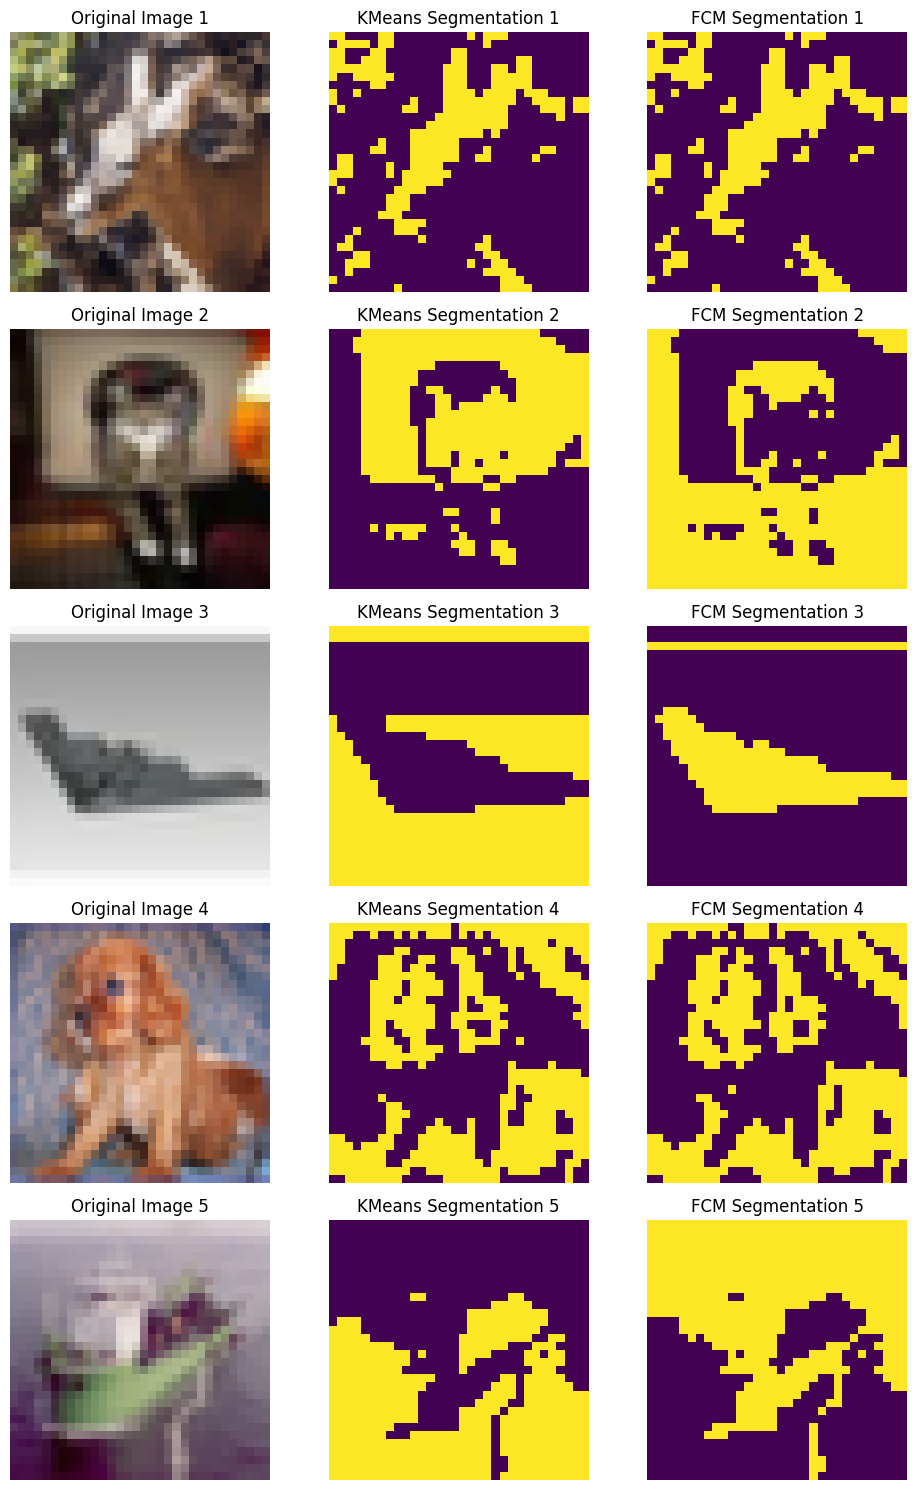

In [5]:
random_indices = np.random.choice(X_train.shape[0], 5, replace=False)

n_clusters = 2
plt.figure(figsize=(10, 15))
for i, idx in enumerate(random_indices):
    img = X_train[idx].reshape((-1, 1024))
    r = img[0, :].reshape((32, 32))
    g = img[1, :].reshape((32, 32))
    b = img[2, :].reshape((32, 32))
    sample_image = np.zeros((32, 32, 3))
    sample_image[:, :, 0] = r / 255
    sample_image[:, :, 1] = g / 255
    sample_image[:, :, 2] = b / 255
    sample_image_reshaped = sample_image.reshape(-1, 3)  # 重塑为像素的二维数组

    # 使用 KMeans 对图像的像素进行聚类
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(sample_image_reshaped, normalize=True)  # 归一化数据
    kmeans_labels = kmeans.predict(sample_image_reshaped, normalize=True)
    kmeans_segmented = kmeans_labels.reshape(32, 32)

    # 使用 FCM 对图像的像素进行聚类
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(sample_image_reshaped, normalize=True)
    fcm_labels = fcm.predict(sample_image_reshaped, normalize=True)
    fcm_segmented = fcm_labels.reshape(32, 32)

    # 可视化原图和分割结果
    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(sample_image)
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(kmeans_segmented, cmap='viridis')
    plt.title(f'KMeans Segmentation {i+1}')
    plt.axis('off')

    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(fcm_segmented, cmap='viridis')
    plt.title(f'FCM Segmentation {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

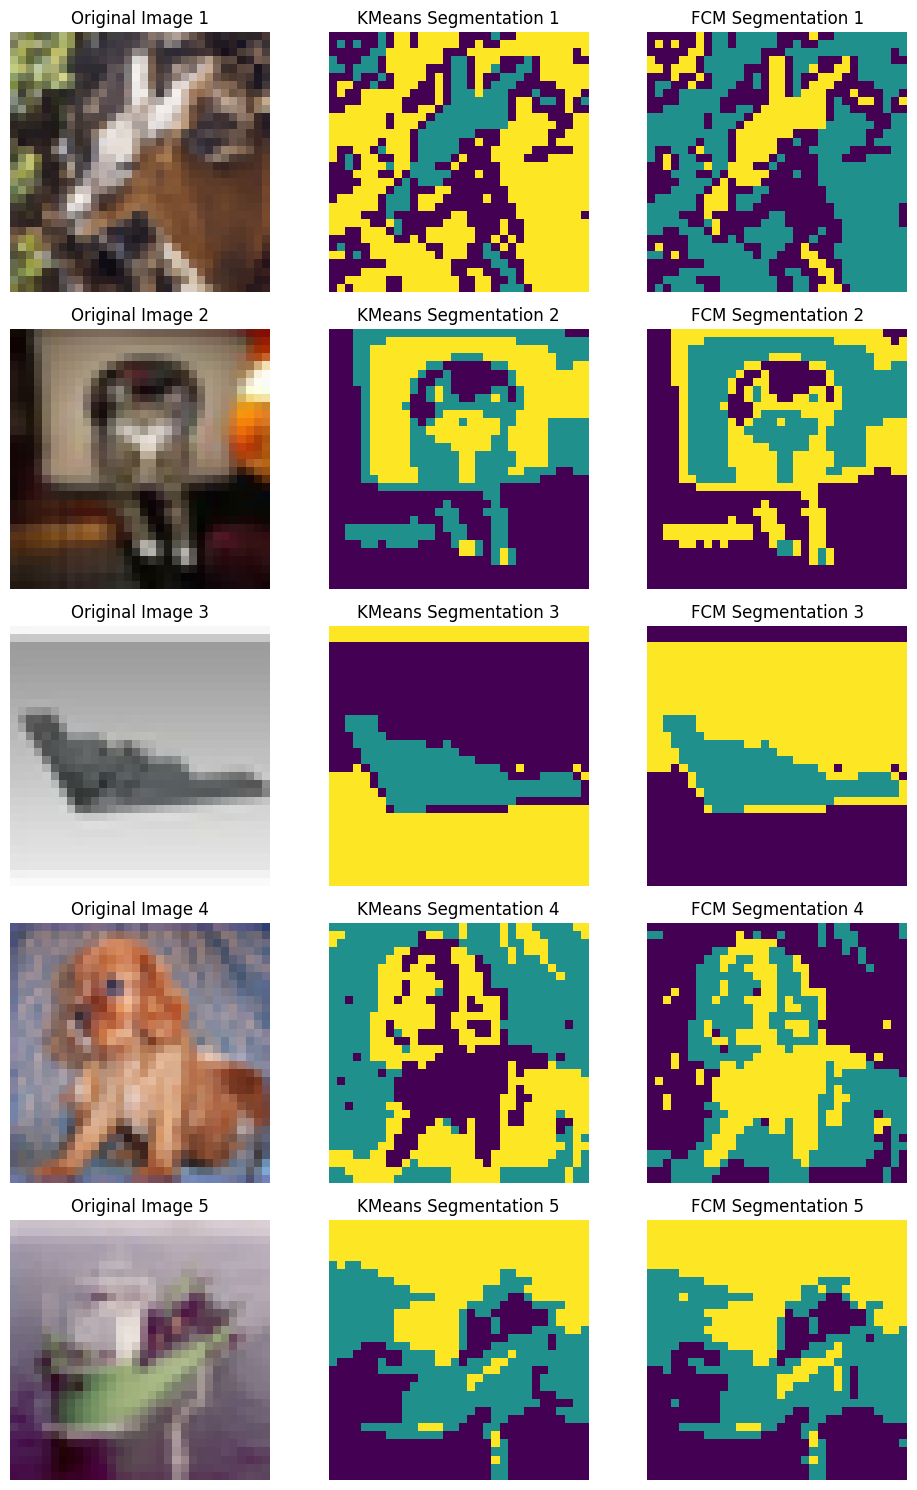

In [6]:
n_clusters = 3
plt.figure(figsize=(10, 15))
for i, idx in enumerate(random_indices):
    img = X_train[idx].reshape((-1, 1024))
    r = img[0, :].reshape((32, 32))
    g = img[1, :].reshape((32, 32))
    b = img[2, :].reshape((32, 32))
    sample_image = np.zeros((32, 32, 3))
    sample_image[:, :, 0] = r / 255
    sample_image[:, :, 1] = g / 255
    sample_image[:, :, 2] = b / 255
    sample_image_reshaped = sample_image.reshape(-1, 3)  # 重塑为像素的二维数组

    # 使用 KMeans 对图像的像素进行聚类
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(sample_image_reshaped, normalize=True)  # 归一化数据
    kmeans_labels = kmeans.predict(sample_image_reshaped, normalize=True)
    kmeans_segmented = kmeans_labels.reshape(32, 32)

    # 使用 FCM 对图像的像素进行聚类
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(sample_image_reshaped, normalize=True)
    fcm_labels = fcm.predict(sample_image_reshaped, normalize=True)
    fcm_segmented = fcm_labels.reshape(32, 32)

    # 可视化原图和分割结果
    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(sample_image)
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(kmeans_segmented, cmap='viridis')
    plt.title(f'KMeans Segmentation {i+1}')
    plt.axis('off')

    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(fcm_segmented, cmap='viridis')
    plt.title(f'FCM Segmentation {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()